# ЗАДАНИЕ 1
# Постановка задачи

Приложение - мобильная утилита для сканирования документов. Модель монетизации подписочная, есть пробный период 7 дней с дальнейшим переходом в оплату 4.99 USD в неделю. В качестве исходных данных предоставлена выгрузка с базы данных по оформлениям подписок и оплат
Каждая строка представляет собой отдельное событие (либо оформление пробной подписки, либо оплата после завершения пробного периода). 

1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ (cohorting event - оформление пробного периода, когорта представляет собой кол-во возможных операций).
2. Спрогнозировать, каким будет LTV на полгода.
3. Построить график, который будет отображать кривую фактического LTV на фоне кривой прогнозируемого LTV.
4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский, цель: узнать как окупятся наши инвестиции).

In [265]:
#Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import math
from sklearn.linear_model import LinearRegression

In [2]:
data_path = 'test case data analyst.xlsx'

In [3]:
#чтение датасета
dataset = pd.read_excel(data_path, sheets = 'raw data')

## 1.Изучение исходных данных. Предобработка

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
dataset = dataset.drop_duplicates()

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114116 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114116 non-null  object        
 1   quantity         114116 non-null  int64         
 2   is_trial_period  114116 non-null  bool          
 3   purchase_date    114116 non-null  datetime64[ns]
 4   user_id          114116 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 4.5+ MB


<div class="alert alert-block alert-success"><span style="color:green">
Дата сет содержит 114116 уникальных записей, спецификация к дата-сету не приложена, определям какие данные содержатся.

In [7]:
#Определение уникальных значений каждого из столбцов
uniqvalue = {}
for column in dataset.columns:
    uniqvalue[column] = len(dataset[column].unique())
    
print(uniqvalue)

{'product_id': 1, 'quantity': 1, 'is_trial_period': 2, 'purchase_date': 51, 'user_id': 62909}


In [8]:
display(dataset.sample(5))

,product_id,quantity,is_trial_period,purchase_date,user_id
90529,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-12,8574601
112153,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-07,8432906
14441,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-10,9022373
58046,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-04,9265470
27916,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-03,9222925


In [452]:
dataset['purchase_date'].describe() 

count         114116
unique            51
top       2020-02-13
freq            3343
Name: purchase_date, dtype: object

<div class="alert alert-block alert-success"><span style="color:green">

В датасете присутсвуют следующие данные:
* product_id -  наименование тестируемого продукта. Единый для всех пользователей - 1week_4.99_USD_subscription_7days_trial
* quantity - количество (вероятно подписок). Единое значение для всех = 1
* is_trial_period - является ли период пробным, принимает два булевых значения
* purchase_date - дата взаимодействия пользователя с сервисом (первая регистрация, последующие оплаты) за 51 день
* user_id - id пользователя

In [10]:
dataset['purchase_date'] = pd.to_datetime(dataset['purchase_date']).dt.date

## 2. Подготовка массива для анализа данных

In [11]:
#Определение первой даты пользования сервисом
first_date = dataset.sort_values(by = ['user_id','purchase_date']).groupby('user_id').agg({'purchase_date':'first'})

In [12]:
#Добавление в основной датасет
dataset = dataset.merge(first_date , on = 'user_id')

In [13]:
#Переименование дублирующихся колонок
dataset = dataset.rename(columns = {'purchase_date_x':'purchase_date','purchase_date_y':'first_date'})

In [14]:
#Вычисление времени жизни в днях
dataset['lifetime'] = (dataset['purchase_date'] - dataset['first_date']).dt.days

In [15]:
#Вычисление времени жизни в неделях
dataset['lifetime_week'] = dataset['lifetime']//7

In [16]:
#Формирование столбца с когортами по неделям
dataset['cohort_week'] = (dataset['first_date']-dt.date(2020,1,1)).dt.days//7

## 3. Определение LTV юзера по данным dataset

In [474]:
def ltv(data,cohort_column,interval,revenue_per_user=4.99, margin_rate=1):
    '''Функция для расчета LTV,принимает на вход:
        data - датасет для анализа
        cohort_column - столбец датасета, в которой содержится название когорты
        interval - столбец датасета, в котором содержатся lifetime
        revenue_per_user - выручка с пользователя, по умолчанию 4.99
        margin_rate - маржинальность, по умолчанию 1
        
        Функция возвращает:
        result_table_ltv_sum - LTV на пользователя по когортам
        result_table_ltv_sum_mean - среднее LTV на пользователя по когортам
    '''
    #Вычисление столбца выручка в зависимости от прибыли с пользователя
    data['revenue'] = (1-data['is_trial_period'])*revenue_per_user*margin_rate
    #создание сводной таблицы ltv по кагортам
    result_table_ltv = pd.pivot_table(data, values='revenue', 
               index=cohort_column, 
               columns=interval, 
               aggfunc='sum')
    #создание сводной таблицы ltv c накоплением
    result_table_ltv_sum_init = result_table_ltv.cumsum(axis = 1)
    #Определение количества людей в когортах
    size_cohort = dataset.groupby(cohort_column).agg({'user_id':'nunique'})
    #Объединение с датасетом с накопленным LTV
    result_table_ltv_sum = result_table_ltv_sum_init.merge(size_cohort, on =cohort_column)
    #Деление датасета на количество пользователей
    result_table_ltv_sum = result_table_ltv_sum.div(result_table_ltv_sum['user_id'],axis = 0).drop(columns = 'user_id')
    #Средний LTV
    result_table_ltv_sum_mean = pd.DataFrame(data = result_table_ltv_sum.mean(axis=0), columns = ['mean_ltv'])
    return result_table_ltv_sum, result_table_ltv_sum_mean

<div class="alert alert-block alert-success"><span style="color:green">
В функции есть важное допущение, ltv рассчитывается по выручке а не по чистой прибыли, поскольку в исходных данныхнет показателя маржинальности. В функции предусмотрена возможность передачи маржинальности, по умолчанию значение принято равным 1

In [475]:
#Получим данные ltv по когортам, исключив последние две даты так как за последнюю неделю даты не полные
filtered_data = dataset.loc[dataset['purchase_date']<dt.date(2020,2,19)]
ltv_table, ltv_mean = ltv(filtered_data,'cohort_week','lifetime_week')

/Users/artemtrifonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


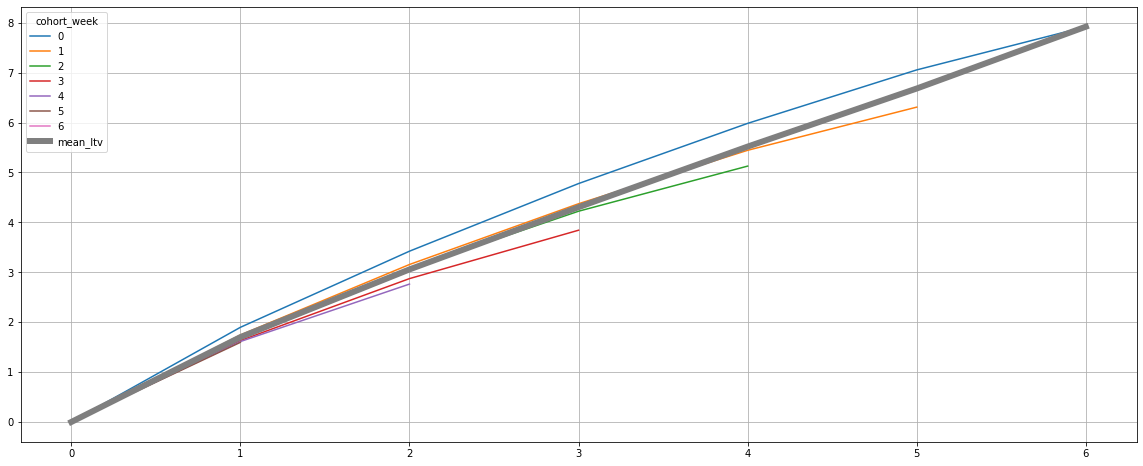

In [19]:
#Добавляем график
fig,ax = plt.subplots()
ltv_table.T.plot(grid = True, figsize = (20,8),ax = ax)
#добавим линию среднего LTV
ltv_mean.plot(grid = True,linewidth = 6,legend = ['mean'], ax = ax)
plt.show()

In [513]:
def my_heat_map(table_for_map):
#Функция для визуализации тепловой карты
    plt.figure(figsize = (15,5))
    sns.heatmap(
        table_for_map, 
        annot = True, 
        linewidth = .5,
        cmap = 'Oranges',
        fmt=".4f"
    )
    plt.show()

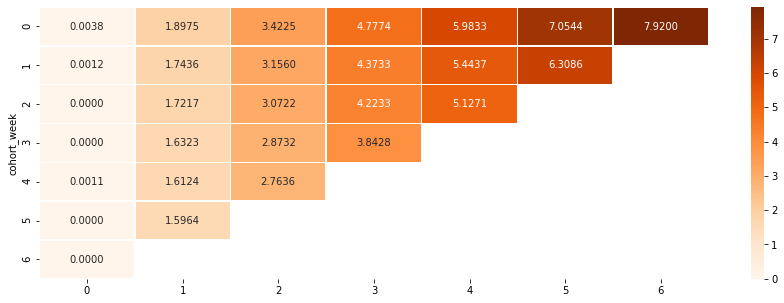

In [514]:
my_heat_map(ltv_table)

<div class="alert alert-block alert-success"><span style="color:green">
    
* В первой когорте LTV в каждый из месяцев стабильно выше других когорт(нет данных что бы сформулировать гипотезы, с чем связана лояльность пользователей первой когорты). 
* LTV за 7 недель составил 7,9 долларов на человека
* В исходных данных отсутсвуют данные о маржинальности, LTV посчитан из выручки

# 4.Прогнозирование LTV на полгода

<div class="alert alert-block alert-success"><span style="color:green">

* Прогнозирование выполнено с помощью метода линейной регрессии в библиотеки библиотеки sklearn
* Прогнозирование выполнено по самой первой когорте, поскольку по ней имеется наибольшое колиечество данных. Использование среднего LTV в данном случае приведет к завышению
* С помощью реализованных функций есть возможность рассчитать прогнозный LTV для всех когорт

In [530]:
#Формирование тестовой выборки для обучения модели
x_test = np.array(list(ltv_table.index)).reshape(-1, 1)
y_test = np.array(list(ltv_table.loc[0][0:7]))
#Формирование выборки для прогноза
x_pred = np.array(range(0,26)).reshape(-1,1)

In [418]:
def make_list(range1,range2,coeff1,coeff2):
#Функция которая возвращает массив для модели машинного обучения по типу логарифма
    x_list=[math.log(x+coeff2) for x in range(range1,range2)]
    x = np.zeros((range2-range1,2))
    x[::,0]=coeff1
    x[::,1]=x_list
    return x

In [524]:
def predict_func (x_train,y_train, x_predict):
#Функция для расчета прогнозных методом линейной регрессии
    lm = LinearRegression()
    lm.fit(x_train,y_train)
    y_pred = lm.predict(x_predict)
    return y_pred
    

In [533]:
def plot_ltv_result(x_fact, yfact,x_test, y_pred):
#Функция для построения графика факта и прогноза
    fig, ax = plt.subplots()
    fig.width = 20
    ax.plot(x_fact, yfact, linewidth=5.0)
    ax.plot(x_test,y_pred, linewidth=2.0)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    plt.grid(True)
    fig.show()
    

/Users/artemtrifonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


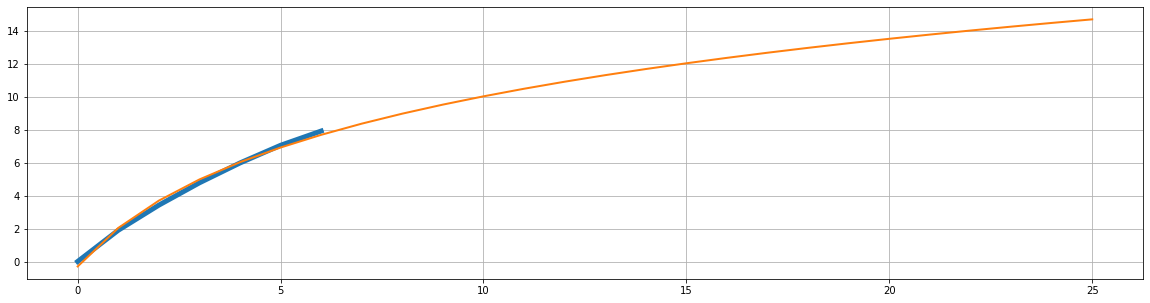

In [534]:
y_pred = predict_func (make_list(0,7,1,2), y_test, make_list(0,26,1,2))
plot_ltv_result(x_test,y_test,x_pred,y_pred)

<div class="alert alert-block alert-success"><span style="color:green">

* Прогнозный LTV за полгода равен 14,5 долларов на пользователя. 
* Модель упрощенная. Прогностичнская способность низкая, ввиду небольшого объема данных - 7 недель
* Можно построить более точную модель, проведя более детальный анализ пользователей (для этого необходимо получить датасет с информацией о пользователях) и более детальную информацию о их взаимодействии с платформой

## 5. Расчет фактического и прогнозного ROMI

In [488]:
def romi(data_ltv,costs_per_user=6):
#Функция для расчета ROMI по когортам
    romi = data_ltv/costs_per_user
    return romi

In [504]:
romi_table = romi(ltv_table)

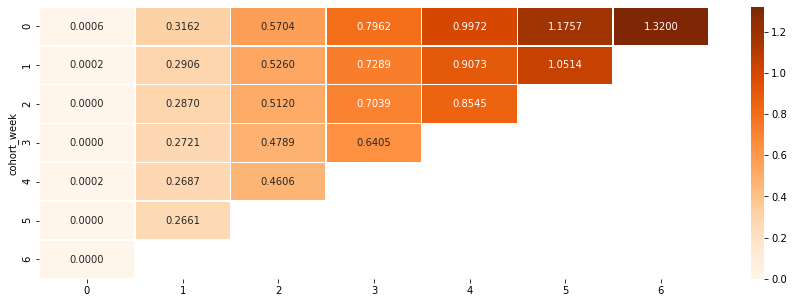

In [515]:
my_heat_map(romi_table)

<div class="alert alert-block alert-success"><span style="color:green">
Исходя из когортного анализа операционные затраты на рекламу окупаются с 6 недели пользования сервисом.
Такая тенденция наблюдается для первых двух когорт, однако может не наблюдаться для последующих когорт, ввиду тенденции по уменьшению LTV с каждой следующей когортой

In [519]:
#формируем массив для обучения модели
y_test_romi = np.array(list(romi_table.loc[0][0:7])) 

/Users/artemtrifonov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


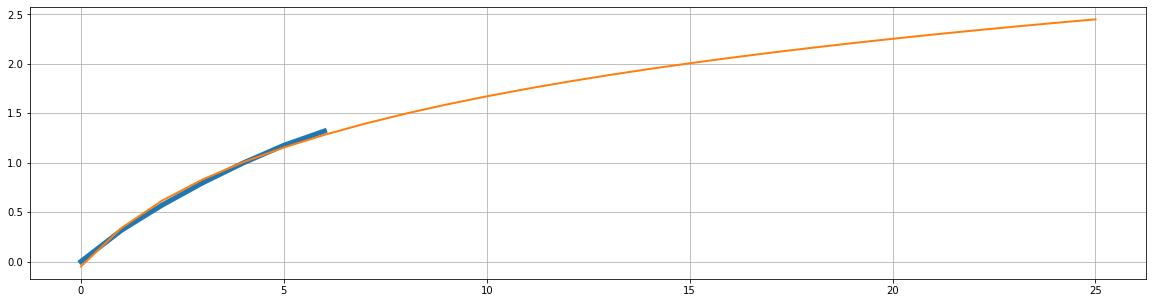

In [535]:
y_pred_romi = predict_func (make_list(0,7,1,2), y_test_romi, make_list(0,26,1,2))
plot_ltv_result(x_test,y_test_romi,x_pred,y_pred_romi)

<div class="alert alert-block alert-success"><span style="color:green">

* Прогнозный ROMI за полгода равен 2,5. Прогнозный ROMI на последующие 4 недели - 1,7
* Модель упрощенная. Прогностичнская способность низкая, ввиду небольшого объема данных - 7 недель
* Можно построить более точную модель, проведя более детальный анализ пользователей (для этого необходимо получить датасет с информацией о пользователях) и более детальную информацию о их взаимодействии с платформой

<div class="alert alert-block alert-success"><span style="color:green">

### Общие выводы:
* В первой когорте LTV в каждый из месяцев стабильно выше других когорт(нет данных что бы сформулировать гипотезы, с чем связана лояльность пользователей первой когорты). 
* LTV за 7 недель составил 7,9 долларов на человека (В исходных данных отсутсвуют данные о маржинальности, LTV посчитан из выручки)
* Прогнозный LTV за полгода равен 14,5 долларов на пользователя. Модель упрощенная. Прогностичнская способность низкая, ввиду небольшого объема данных - 7 недель
* Исходя из когортного анализа операционные затраты на рекламу окупаются с 6 недели пользования сервисом.
Такая тенденция наблюдается для первых двух когорт, однако может не наблюдаться для последующих когорт, ввиду тенденции по уменьшению LTV с каждой следующей когортой
* Прогнозный ROMI за полгода равен 2,5. Прогнозный ROMI на последующие 4 недели - 1,7

# ЗАДАНИЕ 2

* Ниже 2 задачи на проверку знаний SQL.
* Для решения заданий следует использовать синтаксис - PostgreSQL. 
* Ответы нужно представить в виде файла с запросами.

1) Написать 2 SQL запроса для поиска значений среднего и медианы по сумме продажи. 
* Сумму транзакции округляем до целой части. 
* Нельзя использовать стандартные функции среднего и медианы в SQL. 
* Можно использовать только агрфункции SUM и COUNT.

Схема данных:
* ● orders
* ○ id
* ○ sale_amount - в центах
* ○ user_id
* ○ datetime

2) Написать SQL-запрос для поиска задублированных в результате ошибки транзакций

Схема данных
* ● purchases
* ○ transaction_id
* ○ datetime
* ○ amount
* ○ user_id

3) Написать SQL-запрос для построения воронки перехода из установки в оформление пробного периода и в покупку платной версии приложения в разрезе стран. 
* На одного юзера возможна только одно оформление пробного периода и одна покупка платной версии. 
* Покупка возможна только после истечения срока пробного
периода. 
* На выходе должна получится таблица с колонками “country”, “installs”, “trials”, “purchases”, “conversion_rate_to_trial”, “conversion_rate_to_purchase”

Схема данных:
* ● events
* ○ transaction_id
* ○ datetime
* ○ event_type (значение может быть либо “instal”, либо “trial”, либо “purchase”)
* ○ user_id
* ○ country

# ЗАДАНИЕ 3

Продуктовый менеджер сформировал гипотезу, что новая версия экрана продаж будет лучше перформить по сравнению со старой, в связи с тем, что на новом экране продаж более понятно описаны преимущества платной версии приложения.

Продуктовый менеджер ожидает увеличение уровня конверсии из установки в покупкуплатной версии приложения. Приложение тем временем уже очень активнопродвигается на рынке, каждый день привлекается в среднем по 30 000 новых пользователей, текущий уровень конверсии из установки в покупку 5%.

Как бы вы предложили проверить данную гипотезу, какие инструменты и тесты бы использовали в процессе проверки?

<div class="alert alert-block alert-success"><span style="color:green">
    
### Предлагаемое решение
    
1) Для проверки гипотезы о целесообразности переоформления экрана необходимо проведение A/A теста, а затем А/B теста
    
2) Проведение A/A теста необходимо для проверки корректности разделение трафика между группами, проверки корректности сохранения данных аналитики. В данном случае трафик делится пополам, проверяется работоспособность системы перед A/B тестом. При проведении A/A теста проверяются гипотезы:
   * H0: статистически значимых различий между группами A/A теста нет (не более 1%)
   * H1: между группами A/A теста существуют статистически значимые различия
    
    Если верна нулевая гипотеза, то можно приступать к A/B тесту, если верна альтернативная гипотеза - необходимо выяснение причины отклонений, повторно провести А/А тест и потом переходить к A/B тесту
    
    
3) При A/B тесте трафик разделяется на два потока. Одной части пользователей показывают старый экран, другой части пользователей - новый. При этом важно, что бы A/B тест проводился для одной категории пользователей (например географическое положение, возраст), что бы исключить другие влияющие факторы при проверке гипотез.
    
4) При проведении A/B теста проверяются 2 гипотезы
* H0: статистически значимых различий в конверсии между пользователями нет (не более 5%)
* H1: существуют статистически значимые различия в конверсии между пользователями
    
Если верна нулевая гипотеза, возможны 2 варианта развития событий: 
* Прекращение A/B теста, сохранение изначального вида экрана,
* Продление A/B теста
    
Если верна альтернативная гипотеза принимаем решение о смене экрана на новый.
    
Проверка гипотез осуществляется с помощью встроенных функций библиотеки scipy.stats